In [13]:
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Convolution2D,Flatten,Dense,Dropout,MaxPooling2D,Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
data = np.load('Preprocessed_data.npy')
imgs = data[0]
steering = data[1]

#splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(imgs, steering, test_size= 0.2)

In [3]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(18271,)
(4568,)
(18271,)
(4568,)


### Image Processing, Batch generator and Image Augmentation

In [4]:
#refer to Image Processing notebook for more details
#about this cell

#Now combining the brigtness control and
#image fliping in one function
#this function of augmentation is also going to
#be a batch generator

def batch_generator(imgs,steering,batch_size):
    
    #infinite loop
    while True:
        
        X=[]
        y=[]
        
        #running the whole process for each batch of images
        for i in range(batch_size):
        
            #getting random image index from imgs
            index = np.random.randint(0,len(imgs)-1)
            #passing and reading the random image index
            img = cv.imread(imgs[index])
            
            #converting the image to yuv as discussed above
            img = cv.cvtColor(img, cv.COLOR_BGR2YUV)
            #or img = bgr2yuv(img)
            
            #cropping image as discussed above
            img = img[60:135,:,:]
            #or img = crop_img(img)
            
            #adjusting for the model's first layer  with size (66,200,3) as input
            img = cv.resize(img, (200,66))
            
            #instead of going for each image brigntness control
            #we will go for only random images
            if (np.random.rand()>0.5):
                #brightness control
                brigtness_cont = np.random.randint(1,4)
                img = (img/ brigtness_cont).astype(np.uint8)

            #similarly for fliping the image
            if (np.random.rand()>0.5):
                #image fliping
                img = cv.flip(img,1)
                steering_angle = -float(steering[index])
            else:
                steering_angle = float(steering[index])

            X.append(img)
            # y.append(steering_angle)
            y.append(float(steering[index]))
        
        #converting the image 
        # and steering_angle processed into the numpy array
        X = np.array(X)
        y = np.array(y)
        
        
        #Yield is a keyword in Python that is used to return from a function 
        #without destroying the states of its local variable and
        #when the function is called, the execution starts from the last yield statement. 
        #Any function that contains a yield keyword is termed a generator. 
        #Hence, yield is what makes a generator. 
        yield X,y

In [4]:
def batch_generator(imgs,steering,batch_size):
    
    while True:
        
        X=[]
        y=[]
        
        for i in range(batch_size):
        
            index = np.random.randint(0,len(imgs)-1)
            img = cv.imread(imgs[index])
            
            img = cv.cvtColor(img, cv.COLOR_BGR2YUV)
            
            img = img[60:135,:,:]
            
            img = cv.resize(img, (200,66))

            if (np.random.rand()>0.5):
                brigtness_cont = np.random.randint(1,4)
                img = (img/ brigtness_cont).astype(np.uint8)

            if (np.random.rand()>0.5):
                img = cv.flip(img,1)
                steering_angle = -float(steering[index])
            else:
                steering_angle = float(steering[index])

            X.append(img)
            y.append(float(steering[index]))
        
        X = np.array(X)
        y = np.array(y)
        
        yield X,y

In [15]:
model = Sequential()

model.add(Lambda(lambda x : x/127.5 - 1.0, input_shape=(66,200,3)))
model.add(Convolution2D(24, (5,5), strides = (2,2), activation = 'elu'))
model.add(Convolution2D(36, (5,5), strides =(2,2), activation = 'elu'))
model.add(Convolution2D(48, (5,5), strides =(2,2), activation = 'elu'))

model.add(Convolution2D(64, (3,3), activation = 'elu'))
model.add(Convolution2D(64, (3,3), activation = 'elu'))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(100, activation = 'elu'))
model.add(Dense(50, activation = 'elu'))
model.add(Dense(10, activation = 'elu'))
model.add(Dense(1, activation = 'elu'))

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mse')

In [16]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 66, 200, 3)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_22 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_23 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_24 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_2 (Dropout)         (None, 1, 18, 64)        

In [17]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('min_loss_model_50.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

In [24]:
#taking len(X_train)//64 = 36 images for steps for each epoch 
history = model.fit(batch_generator(X_train,y_train,64), steps_per_epoch = 300, epochs = 100, callbacks = [mc],
                    validation_data = batch_generator(X_test,y_test,64), validation_steps = 200)

Epoch 1/50
300/300 [==============================] - 441s 1s/step - loss: 0.0433 - val_loss: 0.0334
Epoch 2/50
300/300 [==============================] - 139s 465ms/step - loss: 0.0359 - val_loss: 0.0326
Epoch 3/50
300/300 [==============================] - 58s 195ms/step - loss: 0.0327 - val_loss: 0.0308
Epoch 4/50
300/300 [==============================] - 37s 122ms/step - loss: 0.0312 - val_loss: 0.0285
Epoch 5/50
300/300 [==============================] - 28s 94ms/step - loss: 0.0302 - val_loss: 0.0287
Epoch 6/50
300/300 [==============================] - 26s 87ms/step - loss: 0.0289 - val_loss: 0.0272
Epoch 7/50
300/300 [==============================] - 28s 92ms/step - loss: 0.0275 - val_loss: 0.0265
Epoch 8/50
300/300 [==============================] - 26s 88ms/step - loss: 0.0266 - val_loss: 0.0271
Epoch 9/50
300/300 [==============================] - 26s 85ms/step - loss: 0.0269 - val_loss: 0.0259
Epoch 10/50
300/300 [==============================] - 25s 84ms/step - loss: 0.

In [24]:
#taking len(X_train)//64 = 36 images for steps for each epoch 
history = model.fit(batch_generator(X_train,y_train,64), steps_per_epoch = 300, epochs = 100, callbacks = [mc],
                    validation_data = batch_generator(X_test,y_test,64), validation_steps = 200)

Epoch 1/50
300/300 [==============================] - 441s 1s/step - loss: 0.0433 - val_loss: 0.0334
Epoch 2/50
300/300 [==============================] - 139s 465ms/step - loss: 0.0359 - val_loss: 0.0326
Epoch 3/50
300/300 [==============================] - 58s 195ms/step - loss: 0.0327 - val_loss: 0.0308
Epoch 4/50
300/300 [==============================] - 37s 122ms/step - loss: 0.0312 - val_loss: 0.0285
Epoch 5/50
300/300 [==============================] - 28s 94ms/step - loss: 0.0302 - val_loss: 0.0287
Epoch 6/50
300/300 [==============================] - 26s 87ms/step - loss: 0.0289 - val_loss: 0.0272
Epoch 7/50
300/300 [==============================] - 28s 92ms/step - loss: 0.0275 - val_loss: 0.0265
Epoch 8/50
300/300 [==============================] - 26s 88ms/step - loss: 0.0266 - val_loss: 0.0271
Epoch 9/50
300/300 [==============================] - 26s 85ms/step - loss: 0.0269 - val_loss: 0.0259
Epoch 10/50
300/300 [==============================] - 25s 84ms/step - loss: 0.

In [22]:
# print("The validation accuracy is :", history.history['val_accuracy'])
# print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])

The validation loss is : [0.03336939215660095, 0.032586172223091125, 0.03084762766957283, 0.02854510024189949, 0.02872016839683056, 0.027167703956365585, 0.026534145697951317, 0.02712448127567768, 0.025865977630019188, 0.02499328926205635, 0.025528177618980408, 0.024358466267585754, 0.024772582575678825, 0.024230197072029114, 0.024691246449947357, 0.024467887356877327, 0.023799560964107513, 0.024297649040818214, 0.024094225838780403, 0.023487545549869537, 0.023465316742658615, 0.023439627140760422, 0.022564545273780823, 0.02235283888876438, 0.02213430218398571, 0.0220329612493515, 0.02235216647386551, 0.020920472219586372, 0.02163979597389698, 0.022156545892357826, 0.021155688911676407, 0.020976554602384567, 0.021567311137914658, 0.020728163421154022, 0.021769268438220024, 0.020714793354272842, 0.02122291550040245, 0.020817464217543602, 0.019499532878398895, 0.020381253212690353, 0.0197721179574728, 0.019889598712325096, 0.02115669660270214, 0.020431052893400192, 0.01970042660832405, 0

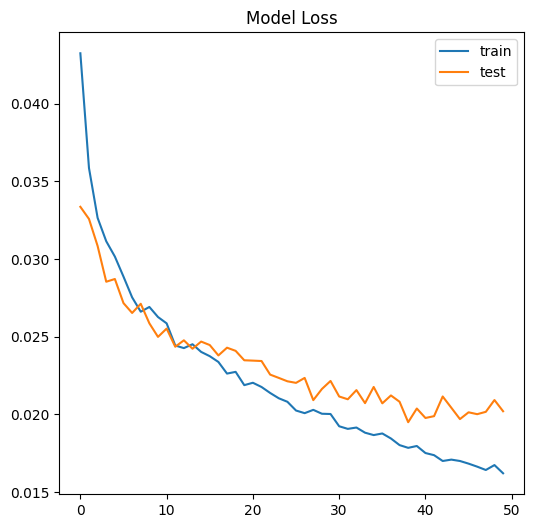

In [23]:
plt.figure(figsize = (6,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Model Loss")
plt.show()

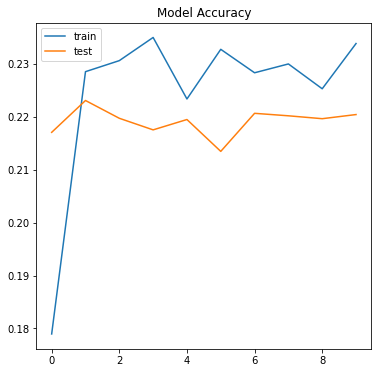

In [31]:
plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title("Model Accuracy")
plt.show()

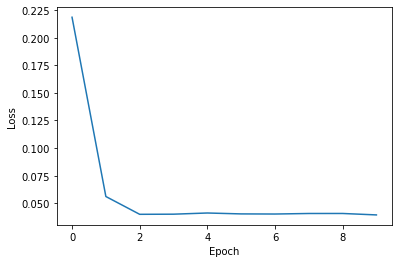

In [21]:
plt.plot(history.history['loss'])

plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.show()

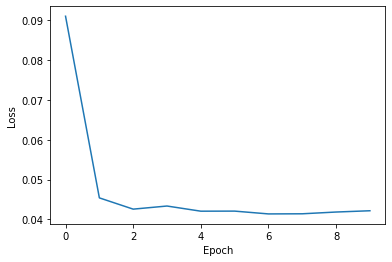

In [22]:
plt.plot(history.history['val_loss'])

plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.show()

In [23]:
model.save('Model.h5')